# Chapter 3: Stochastic Simulations in pymc2

This tutorial will show you how to use GemPy for stochastic simulation of geological models. We will address two approaches for this: (i) Monte Carlo forward simulation, treating input data as uncertain parameter distributions; (ii) Bayesian inference, where we extent the approach with the use of likelihood functions to constrain the stochastic modeling results with additional data.


## Preparation

Import GemPy, matplotlib for plotting, numpy and pandas for data handling.

In [1]:
import sys, os
sys.path.append("../..")

# import gempy
import gempy as gp

# inline figures in jupyter notebooks
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pn
import theano

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Initialize an example model

First we define the cube size and model extent of our model and initialize the GemPy data object:

In [2]:
# set cube size and model extent
cs = 50
extent = (3000, 200, 2000)  # (x, y, z)
res = (120, 4, 80)

In [3]:
# initialize geo_data object
geo_data = gp.create_data([0, extent[0],
                           0, extent[1], 
                           0, extent[2]],
                          resolution=[res[0],  # number of voxels
                                      res[1], 
                                      res[2]])

Then we use pandas to load the example data stored as csv files:

In [4]:
geo_data.set_interfaces(pn.read_csv("../input_data/tut_chapter3/tutorial_ch3_interfaces",
                                    index_col="Unnamed: 0"), append=True)
geo_data.set_orientations(pn.read_csv("../input_data/tut_chapter3/tutorial_ch3_foliations",
                                    index_col="Unnamed: 0"))

We can visualize (and modify making use of an interactive backend) the stratigraphic pile. Since the formations are arbitary we can set them by:

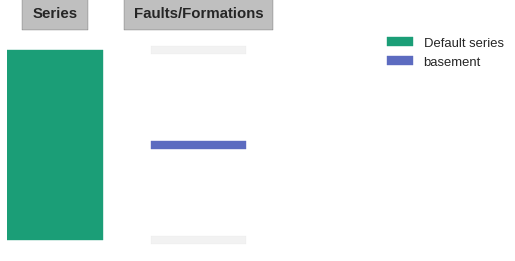

In [5]:
# Original pile
gp.get_sequential_pile(geo_data)

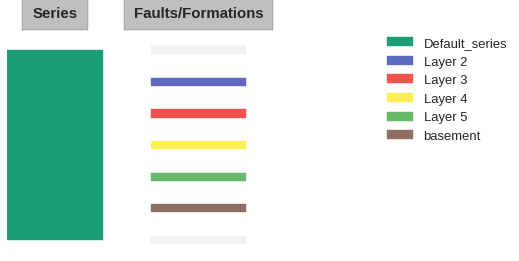

In [6]:
# Ordered pile
gp.set_series(geo_data, {'Default_series':['Layer 2', 'Layer 3', 'Layer 4','Layer 5']})
gp.get_sequential_pile(geo_data)

In [7]:
# and at all of the foliation data
gp.get_data(geo_data, 'orientations', verbosity=0)

,X,Y,Z,G_x,G_y,G_z,dip,azimuth,polarity,formation,series,formation_number,order_series,isFault
0,500.0,100.0,1148.000000,-0.516992,-0.008559,0.855947,31.135451,269.051481,1.0,Layer 2,Default_series,1,1,False
1,2500.0,100.0,1147.333333,0.516122,-0.014273,0.856396,31.085652,91.584103,1.0,Layer 2,Default_series,1,1,False


## Visualize the input data

Now let's have a look at the data in the xz-plane:

../../gempy/gempy_front.py:927: FutureWarning: gempy plotting functionality will be moved in version 1.2, use gempy.plotting module instead
  warnings.warn("gempy plotting functionality will be moved in version 1.2, use gempy.plotting module instead", FutureWarning)


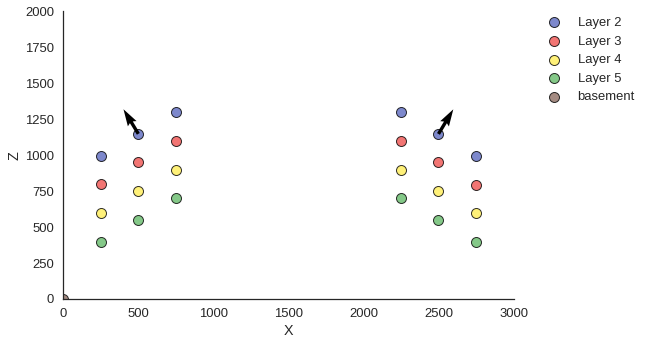

In [8]:
gp.plot_data(geo_data, direction="y")
plt.xlim(0,3000)
plt.ylim(0,2000);

At this point we should store the input data object as a pickle, for future reference:

In [9]:
gp.data_to_pickle(geo_data, "./bin/pickles/ch3-pymc2_tutorial_geo_data")

## Compile the interpolator function

Now that we have some input data, the next step is to compile the interpolator function of GemPy with the imported model setup and data:

In [10]:
interp_data = gp.InterpolatorData(geo_data, compile_theano=True)

Compiling theano function...
Compilation Done!
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float32
Number of faults:  0


Afterwards we can compute the geological model:

In [11]:
lith_block, fault_block = gp.compute_model(interp_data)

And plot a section:

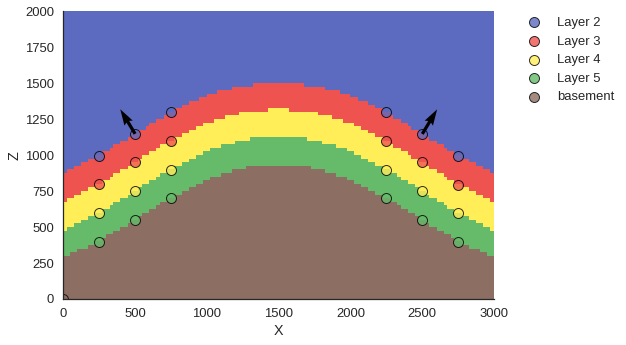

In [12]:
gp.plotting.plot_section(geo_data, lith_block[0], 2, plot_data = True)

## Setting up the pymc-Functions

pymc has two distinct types of objects: **deterministic** and **stochastic** objects. As the [pymc documentation](https://pymc-devs.github.io/pymc/modelbuilding.html)  puts it: "A *Stochastic* object represents a variable whose value is not completely determined by its parents, and a *Deterministic* object represents a variable that is entirely determined by its parents." Stochastic objects can essentially be seen as *parameter distributions* or *likelihood functions*, while Deterministic objects can be seen as function that take a specific input and return a specific (determined) output for this input. An example for the latter would be the modeling function of GemPy, which takes a specific set of input parameters and always creates the same model from those parameters.

In [13]:
import pymc

## Setting up the parameter distributions

For conducting a stochastic simulation of the geological model, we need to consider our input data (dips and layer interfaces) as uncertain - i.e. as distributions.

In [14]:
# Checkpoint in case you did not execute the cells above
geo_data = gp.read_pickle("bin/pickles/ch3-pymc2_tutorial_geo_data.pickle")

In [15]:
gp.get_data(geo_data, 'orientations', verbosity=1).head()

,X,Y,Z,G_x,G_y,G_z,dip,azimuth,polarity,formation,series,formation_number,order_series,isFault,formation_value,annotations
0,500.0,100.0,1148.000000,-0.516992,-0.008559,0.855947,31.135451,269.051481,1.0,Layer 2,Default_series,1,1,False,1,"${\bf{x}}_{\beta \,{\bf{1}},0}$"
1,2500.0,100.0,1147.333333,0.516122,-0.014273,0.856396,31.085652,91.584103,1.0,Layer 2,Default_series,1,1,False,1,"${\bf{x}}_{\beta \,{\bf{1}},1}$"


So let's assume the vertical location of our layer interfaces is uncertain, and we want to represent this uncertainty by using a normal distribution. To define a normal distribution, we need a mean and a measure of deviation (e.g. standard deviation). For convenience the input data is already grouped by a "group_id" value, which allows us to collectively modify data that belongs together. In this example we want to treat the vertical position of each layer interface, on each side of the anticline, as uncertain. Therefore, we want to perturbate the respective three points on each side of the anticline collectively.

These are our unique group id's, the number representing the layer, and a/b the side of the anticline.

In [16]:
group_ids = geo_data.interfaces["group_id"].dropna().unique()
print(group_ids)

['l2_a' 'l2_b' 'l3_b' 'l3_a' 'l4_a' 'l4_b' 'l5_b' 'l5_a']


As a reminder, GemPy stores data in two main objects, an InputData object (called geo_data in the tutorials) and a InpterpolatorInput object (interp_data) in tutorials. geo_data contains the original data while interp_data the data prepared (and compiled) to compute the 3D model. 

Since we do not want to compile our code at every new stochastic realization, from here on we will need to work with thte interp_data. And remember that to improve float32 to stability we need to work with rescaled data (between 0 and 1). Therefore all the stochastic data needs to be rescaled accordingly. The object interp_data contains a property with the rescale factor (see below. As default depends on the model extent), or it is possible to add the stochastic data to the pandas dataframe of the geo_data---when the InterpolatorInput object is created the rescaling happens under the hood. 

In [17]:
interface_Z_modifier = []

# We rescale the standard deviation
std = 20./interp_data.rescaling_factor

# loop over the unique group id's and create a pymc.Normal distribution for each
for gID in group_ids:
    stoch = pymc.Normal(gID+'_stoch', 0, 1./std**2)
    interface_Z_modifier.append(stoch)

our list of parameter distribution:

In [18]:
interface_Z_modifier

[<pymc.distributions.new_dist_class.<locals>.new_class 'l2_a_stoch' at 0x7f560d44dc88>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'l2_b_stoch' at 0x7f560d44d5c0>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'l3_b_stoch' at 0x7f560d44dfd0>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'l3_a_stoch' at 0x7f560d44d208>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'l4_a_stoch' at 0x7f560d44d080>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'l4_b_stoch' at 0x7f560d3e5978>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'l5_b_stoch' at 0x7f560d2b1208>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'l5_a_stoch' at 0x7f560d2a6940>]

Let's have a look at one:

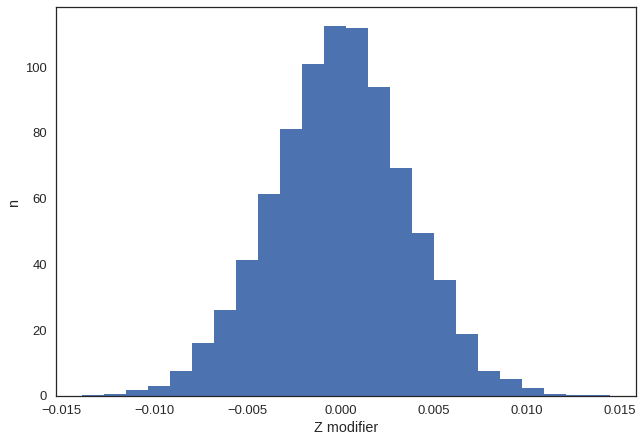

In [19]:
# sample from a distribtion
samples = [interface_Z_modifier[3].rand() for i in range(10000)]
# plot histogram
plt.hist(samples, bins=24, normed=True);
plt.xlabel("Z modifier")
plt.vlines(0, 0, 0.01)
plt.ylabel("n");

 Now we need to somehow sample from these distribution and put them into GemPy

## Input data handling

First we need to write a function which modifies the input data for each iteration of the stochastic simulation. As this process is highly dependant on the simulation (e.g. what input parameters you want modified in which way), this process generally can't be automated. 

The idea is to change the column Z (in this case) of the rescaled dataframes in our interp_data object (which can be found in interp_data.geo_data_res). First we simply create the pandas Dataframes we are interested on:

In [20]:
import copy
# First we extract from our original intep_data object the numerical data that is necessary for the interpolation.
# geo_data_stoch is a pandas Dataframe

# This is the inital model so it has to be outside the stochastic frame
geo_data_stoch_init = copy.deepcopy(interp_data.geo_data_res)

In [21]:
gp.get_data(geo_data_stoch_init, numeric=True).head()

X         Y         Z  G_x  G_y  G_z  dip  azimuth  \
interfaces 0  0.295555  0.481918  0.563100  NaN  NaN  NaN  NaN      NaN   
           1  0.386464  0.500100  0.618191  NaN  NaN  NaN  NaN      NaN   
           2  0.341009  0.518282  0.590918  NaN  NaN  NaN  NaN      NaN   
           3  0.750100  0.481918  0.562918  NaN  NaN  NaN  NaN      NaN   
           4  0.659191  0.500100  0.618009  NaN  NaN  NaN  NaN      NaN   

              polarity  
interfaces 0       NaN  
           1       NaN  
           2       NaN  
           3       NaN  
           4       NaN

In [22]:
@pymc.deterministic(trace=True)
def input_data(value = 0, 
               interface_Z_modifier = interface_Z_modifier,
               geo_data_stoch_init = geo_data_stoch_init,
               verbose=0):
    # First we extract from our original intep_data object the numerical data that is necessary for the interpolation.
    # geo_data_stoch is a pandas Dataframe
 #   geo_data_stoch = gp.get_data(interp_data_original.geo_data_res, numeric=True)

    geo_data_stoch = gp.get_data(geo_data_stoch_init, numeric=True)
    # Now we loop each id which share the same uncertainty variable. In this case, each layer.
    for e, gID in enumerate(group_ids):
        # First we obtain a boolean array with trues where the id coincide
        sel = gp.get_data(interp_data.geo_data_res, verbosity=2)['group_id'] == gID
        
        # We add to the original Z value (its mean) the stochastic bit in the correspondant groups id 
        geo_data_stoch.loc[sel, 'Z']  += np.array(interface_Z_modifier[e])
        
    if verbose > 0:
        print(geo_data_stoch)
        
    # then return the input data to be input into the modeling function. Due to the way pymc2 stores the traces
    # We need to save the data as numpy arrays
    return [geo_data_stoch.xs('interfaces')[["X", "Y", "Z"]].values, geo_data_stoch.xs('orientations').values]

## Modeling function

Second, we need a function that takes the modified input data output by the above function, and created our geological model from it. Although, we could store the model itself it tends to be a too large file once we make thousands of iterations. For this reason is preferible to keep the input data and the geological model split and only to store the input data ( which we will use to reconstruct each geological model since that operation is deterministic).

../../gempy/gempy_front.py:953: FutureWarning: gempy plotting functionality will be moved in version 1.2, use gempy.plotting module instead
  "use gempy.plotting module instead", FutureWarning)


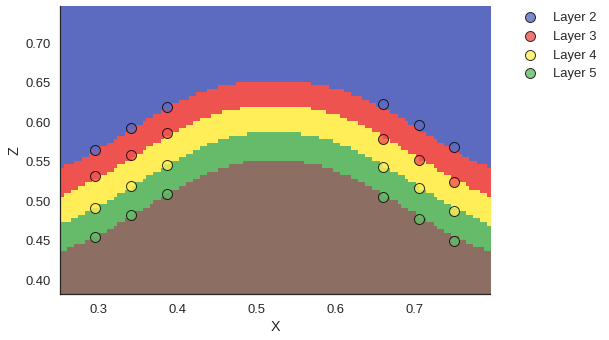

In [23]:
@pymc.deterministic(trace=False)
def gempy_model(value=0,
                input_data=input_data, verbose=True):
    
    # modify input data values accordingly
    interp_data.geo_data_res.interfaces[["X", "Y", "Z"]] = input_data[0]
    
    # Gx, Gy, Gz are just used for visualization.
    # The theano function gets azimuth dip and polarity!!!
    interp_data.geo_data_res.orientations[["G_x", "G_y", "G_z", "X", "Y", "Z",
                                           'dip', 'azimuth', 'polarity']] = input_data[1]
    
    try:
        # try to compute model
        lb, fb = gp.compute_model(interp_data)
        if True:
            gp.plot_section(interp_data.geo_data_res, lb[0], 0, plot_data=True)
           # gp.plot_data(interp_data.geo_data_res, direction='y')

        return lb, fb
    
    except np.linalg.linalg.LinAlgError as err:
        # if it fails (e.g. some input data combinations could lead to 
        # a singular matrix and thus break the chain) return an empty model
        # with same dimensions (just zeros)
        if verbose:
            print("Exception occured.")
        return np.zeros_like(lith_block), np.zeros_like(fault_block)

In [24]:
interp_data.geo_data_res.orientations

,X,Y,Z,G_x,G_y,G_z,dip,azimuth,polarity,formation,series,formation_number,order_series,isFault,formation_value,annotations
0,-0.516992,-0.008559,0.855947,0.341009,0.5001,0.590736,31.135451,269.051481,1.0,Layer 2,Default_series,1,1,False,1,"${\bf{x}}_{\beta \,{\bf{1}},0}$"
1,0.516122,-0.014273,0.856396,0.704645,0.5001,0.590615,31.085652,91.584103,1.0,Layer 2,Default_series,1,1,False,1,"${\bf{x}}_{\beta \,{\bf{1}},1}$"


We then create a pymc model with the two deterministic functions (*input_data* and *gempy_model*), as well as all the prior parameter distributions stored in the list *interface_Z_modifier*:

In [25]:
params = [input_data, gempy_model, *interface_Z_modifier] 
model = pymc.Model(params)

Then we set the number of iterations:

In [26]:
iterations = 100

Then we create an MCMC chain (in pymc an MCMC chain without a likelihood function is essentially a Monte Carlo forward simulation) and specify an hdf5 database to store the results in:

In [27]:
RUN = pymc.MCMC(model, db="hdf5", dbname="bin/pymc-db/ch3-pymc2.hdf5")

and we are finally able to run the simulation:

In [28]:
RUN.sample(iter=100, verbose=0)

 [-----------------100%-----------------] 100 of 100 complete in 7.2 sec

## Analyzing the results

When we want to analyze the results, we first have to load the stored geo_data object:

(this part is only necessary if the notebook above is not executed)

In [29]:
geo_data = gp.read_pickle("bin/pickles/ch3-pymc2_tutorial_geo_data.pickle")

Check the stratigraphic pile for correctness:

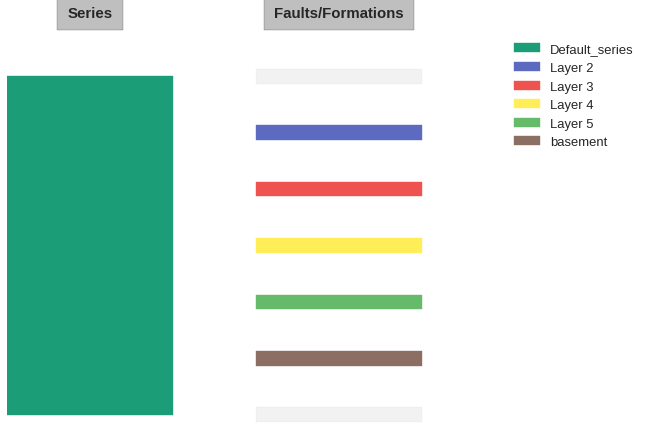

In [30]:
gp.get_sequential_pile(geo_data)

Then we can then compile the GemPy modeling function:

In [31]:
interp_data = gp.InterpolatorData(geo_data)

Now we can reproduce the original model:

Compiling theano function...
Compilation Done!
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float32
Number of faults:  0


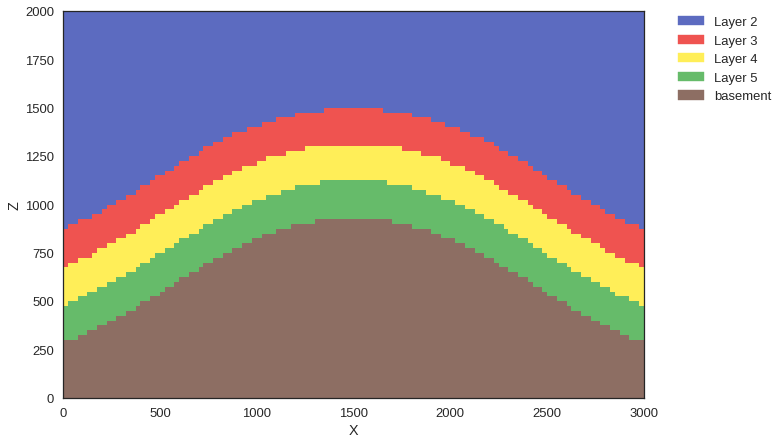

In [32]:
lith_block, fault_block = gp.compute_model(interp_data)
gp.plotting.plot_section(geo_data, lith_block[0], 0)

But of course we want to look at the perturbation results. We have a class for that:

(in the mid term the most important methods of this class will be moved to the gempy main framework---i.e. gp)

In [36]:
import gempy.posterior_analysis
import importlib
importlib.reload(gempy.posterior_analysis)

<module 'gempy.posterior_analysis' from '../../gempy/posterior_analysis.py'>

Which allows us to load the stored pymc2 database

In [37]:
dbname = "bin/pymc-db/ch3-pymc2.hdf5"
post = gempy.posterior_analysis.Posterior(dbname)

Alright, it tells us that we did not tally any GemPy models (we set the trace flag for the gempy_model function to False!). But we can just replace the input data with the ones stored at each iteration. So let's plot the model result of the 85th iteration:

In [38]:
post.change_input_data(interp_data, 80)

Then we compute the model and plot it:

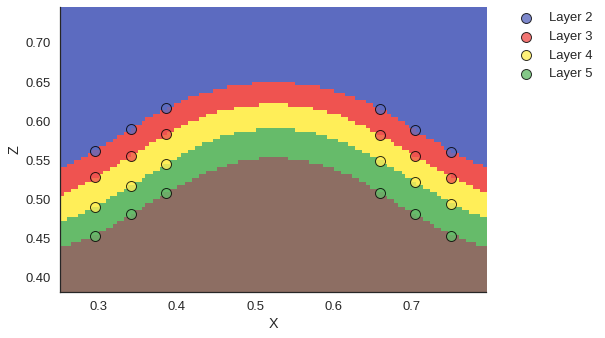

In [43]:
lith_block, fault_block = gp.compute_model(interp_data)
gp.plotting.plot_section(interp_data.geo_data_res, lith_block[0], 2, plot_data=True)

In [44]:
interp_data.geo_data_res.interfaces

,X,X_std,Y,Y_std,Z,Z_std,annotations,formation,formation_number,formation_value,group_id,isFault,order_series,series
0,0.295555,0.0,0.481918,0.0,0.562129,0.0,"${\bf{x}}_{\alpha \,{\bf{1}},0}$",Layer 2,1,1,l2_a,False,1,Default_series
1,0.386464,0.0,0.500100,0.0,0.617220,0.0,"${\bf{x}}_{\alpha \,{\bf{1}},1}$",Layer 2,1,1,l2_a,False,1,Default_series
2,0.341009,0.0,0.518282,0.0,0.589947,0.0,"${\bf{x}}_{\alpha \,{\bf{1}},2}$",Layer 2,1,1,l2_a,False,1,Default_series
3,0.750100,0.0,0.481918,0.0,0.560755,0.0,"${\bf{x}}_{\alpha \,{\bf{1}},3}$",Layer 2,1,1,l2_b,False,1,Default_series
4,0.659191,0.0,0.500100,0.0,0.615846,0.0,"${\bf{x}}_{\alpha \,{\bf{1}},4}$",Layer 2,1,1,l2_b,False,1,Default_series
5,0.704645,0.0,0.518282,0.0,0.588755,0.0,"${\bf{x}}_{\alpha \,{\bf{1}},5}$",Layer 2,1,1,l2_b,False,1,Default_series
6,0.659191,0.0,0.500100,0.0,0.582233,0.0,"${\bf{x}}_{\alpha \,{\bf{2}},0}$",Layer 3,2,2,l3_b,False,1,Default_series
7,0.386464,0.0,0.500100,0.0,0.583335,0.0,"${\bf{x}}_{\alpha \,{\bf{2}},1}$",Layer 3,2,2,l3_a,False,1,Default_series
8,0.341009,0.0,0.518282,0.0,0.556062,0.0,"${\bf{x}}_{\alpha \,{\bf{2}},2}$",Layer 3,2,2,l3_a,False,1,Default_series
9,0.750100,0.0,0.481918,0.0,0.527142,0.0,"${\bf{x}}_{\alpha \,{\bf{2}},3}$",Layer 3,2,2,l3_b,False,1,Default_series


or the 34th:

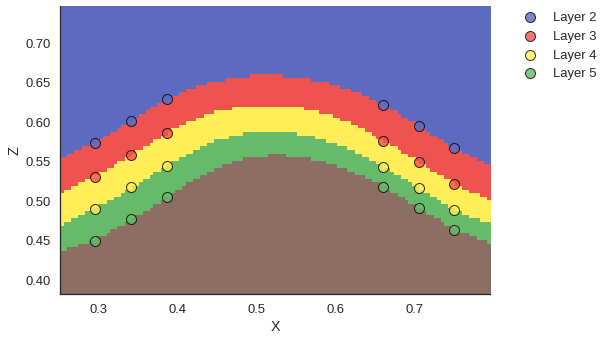

In [45]:
post.change_input_data(interp_data, 15)
lith_block, fault_block = gp.compute_model(interp_data)
gp.plotting.plot_section(interp_data.geo_data_res, lith_block[0], 2, plot_data=True)

In [46]:
interp_data.geo_data_res.interfaces

,X,X_std,Y,Y_std,Z,Z_std,annotations,formation,formation_number,formation_value,group_id,isFault,order_series,series
0,0.295555,0.0,0.481918,0.0,0.573071,0.0,"${\bf{x}}_{\alpha \,{\bf{1}},0}$",Layer 2,1,1,l2_a,False,1,Default_series
1,0.386464,0.0,0.500100,0.0,0.628162,0.0,"${\bf{x}}_{\alpha \,{\bf{1}},1}$",Layer 2,1,1,l2_a,False,1,Default_series
2,0.341009,0.0,0.518282,0.0,0.600889,0.0,"${\bf{x}}_{\alpha \,{\bf{1}},2}$",Layer 2,1,1,l2_a,False,1,Default_series
3,0.750100,0.0,0.481918,0.0,0.565947,0.0,"${\bf{x}}_{\alpha \,{\bf{1}},3}$",Layer 2,1,1,l2_b,False,1,Default_series
4,0.659191,0.0,0.500100,0.0,0.621038,0.0,"${\bf{x}}_{\alpha \,{\bf{1}},4}$",Layer 2,1,1,l2_b,False,1,Default_series
5,0.704645,0.0,0.518282,0.0,0.593947,0.0,"${\bf{x}}_{\alpha \,{\bf{1}},5}$",Layer 2,1,1,l2_b,False,1,Default_series
6,0.659191,0.0,0.500100,0.0,0.575683,0.0,"${\bf{x}}_{\alpha \,{\bf{2}},0}$",Layer 3,2,2,l3_b,False,1,Default_series
7,0.386464,0.0,0.500100,0.0,0.585447,0.0,"${\bf{x}}_{\alpha \,{\bf{2}},1}$",Layer 3,2,2,l3_a,False,1,Default_series
8,0.341009,0.0,0.518282,0.0,0.558175,0.0,"${\bf{x}}_{\alpha \,{\bf{2}},2}$",Layer 3,2,2,l3_a,False,1,Default_series
9,0.750100,0.0,0.481918,0.0,0.520592,0.0,"${\bf{x}}_{\alpha \,{\bf{2}},3}$",Layer 3,2,2,l3_b,False,1,Default_series


or the 95th:

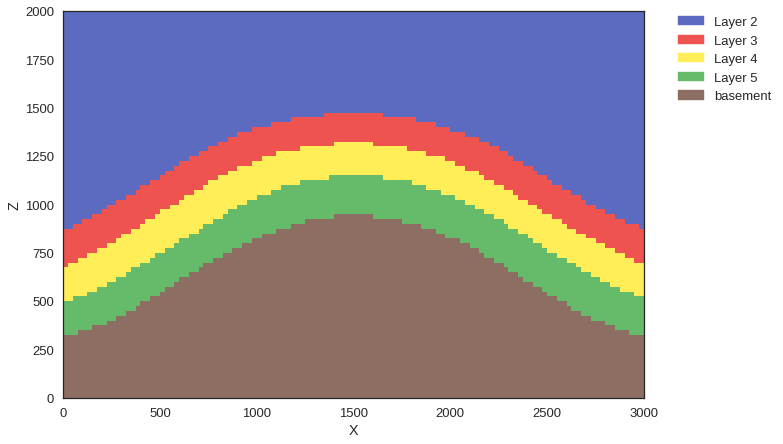

In [41]:
post.change_input_data(interp_data, 95)
lith_block, fault_block = gp.compute_model(interp_data)
gp.plotting.plot_section(geo_data, lith_block[0], 2)

As you can see, we have successfully perturbated the vertical layer interface positions - although only like a 100 times. While some models represent reasonable, geologically meaningful systems, some may not. This is due to the stochastic selection of input parameters and an inherent problem of the approach of Monte Carlo forward simulation - results do not get validated in any sense. This where Bayesian inference comes into play, as a method to constrain modeling outcomes by the use of geological likelihood functions. We will introduce you to the approach and how to use it with GemPy and pymc in the following chapter.

In [ ]:
ver, sim = gp.get_surfaces(interp_data,lith_block[1], None, original_scale= True)
gp.plotting.plot_surfaces_3D_real_time(geo_data, interp_data,
                                       ver, sim, posterior=post, alpha=1)